# MNIST Standard GAN
## Overview
Dataset: MNIST handwritten digits.
Framework: TensorFlow 2.x with Keras API.
GAN Components:
- Generator: Transforms random noise into synthetic MNIST-like images.
- Discriminator: Classifies images as real or fake.
- Loss Function: Binary Cross-Entropy (Standard GAN loss).
- Optimization: Adam optimizer.

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt

Load and Preprocess MNIST Dataset

In [2]:
# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize images to [0, 1] range and add a channel dimension
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Create batches and shuffle the dataset
BUFFER_SIZE = 60000
BATCH_SIZE = 128

dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

Define Discriminator

In [3]:
def build_discriminator():
    model = models.Sequential()
    model.add(
        layers.Conv2D(
            32, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]
        )
    )
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    return model


discriminator = build_discriminator()

c:\Users\jorde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Define Generator

In [4]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 192, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 192)))
    model.add(layers.Dropout(0.4))

    model.add(layers.UpSampling2D())
    model.add(
        layers.Conv2DTranspose(
            96, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.UpSampling2D())
    model.add(
        layers.Conv2DTranspose(
            48, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(
        layers.Conv2DTranspose(
            24, (5, 5), strides=(1, 1), padding="same", use_bias=False
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(
        layers.Conv2DTranspose(
            1,
            (5, 5),
            strides=(1, 1),
            padding="same",
            use_bias=False,
            activation="sigmoid",
        )
    )
    return model


generator = build_generator()

c:\Users\jorde\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Define Loss Functions and Optimizers

In [5]:
# Binary Cross-Entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(
        tf.ones_like(real_output), real_output
    )  # Labels for real images are 1
    fake_loss = cross_entropy(
        tf.zeros_like(fake_output), fake_output
    )  # Labels for fake images are 0
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    # Generator tries to make fake images be classified as real (label = 1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)


# Optimizers
generator_optimizer = optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = optimizers.Adam(learning_rate=1e-4)

Define Training Loop

In [6]:
import os
import time

# Seed for generating images during training
seed = tf.random.normal([16, 100])


# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # Apply gradients to update the weights
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

    return gen_loss, disc_loss


# Directory where the checkpoints will be saved
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Create a checkpoint object
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

from tqdm import tqdm

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in tqdm(
            dataset, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Calculate average losses for the epoch
        avg_gen_loss = np.mean(gen_loss_list)
        avg_disc_loss = np.mean(disc_loss_list)

        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            generator.save(f"generator_epoch_{epoch + 1}.h5")
            discriminator.save(f"discriminator_epoch_{epoch + 1}.h5")

        print(
            f"Epoch {epoch + 1}, Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}, Time: {time.time() - start:.2f} seconds"
        )

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

    # Save the final models
    generator.save("./models/generator_model.h5")
    discriminator.save("./models/discriminator_model.h5")
    checkpoint.save(file_prefix=checkpoint_prefix)

Define a Function to Generate and Save Images

In [7]:
from IPython import display


def generate_and_save_images(model, epoch, test_input):
    # Notice training=False
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.savefig(f"./images/image_at_epoch_{epoch:04d}.png")
    plt.show()

Train

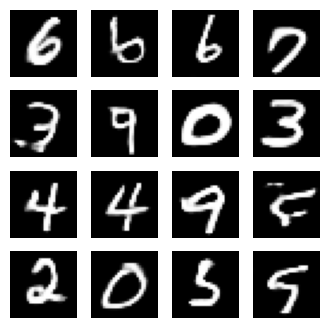

In [8]:
EPOCHS = 50

train(dataset, EPOCHS)